In [29]:
import json
import datetime
import numpy as np
from tqdm import tqdm
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [ ]:
class SampleTimestamps():

    def __init__(self, file_path: str, target_framerate_hz = 1, aws_bucket=None, aws_prefix=None, ):
        self.file_path = file_path
        self.aws_bucket = aws_bucket
        self.aws_prefix = aws_prefix
        self.target_framerate_hz = target_framerate_hz
        self.valid_target_framerate = True
        self.current_framerate_hz = None
        self.timestamps = []

        if file_path:
            self.execution_mode = "local"
        elif aws_bucket and aws_prefix:
            self.execution_mode = "aws"
        else:
            raise ValueError("Either file_path or aws_bucket and aws_prefix must be provided")

    def get_framerate(self
    ):
        timestamps = []

        with open(self.file_path, "r") as file:
            total_lines = sum(1 for _ in file)

        with open(self.file_path, "r") as file:
            for index, line in tqdm(enumerate(file), desc="Collecting data", total=total_lines):
                data = json.loads(line)
                if "time" in data and "data" in data:
                    # Get time data
                    timestamp_raw = data.get("time")
                    timestamp = datetime.datetime.strptime(timestamp_raw, "%Y-%m-%d %H:%M:%S.%f")

                elif (
                    "image" in data
                    and "sensor_name" in data
                    and "event_timestamp" in data
                ):
                    # Get time data
                    timestamp_raw = data.get("event_timestamp")
                    timestamp = datetime.datetime.fromtimestamp(timestamp_raw, tz=datetime.timezone.utc)

                timestamps.append((index, timestamp))

        # Calculate time differences (s) and current framerate (Hz)
        time_differences = []
        timestamps = sorted(timestamps, key=lambda x: x[1])

        previous_time = None
        for index, timestamp in tqdm(timestamps, desc="Calculating time differences"):
            if previous_time is not None:
                time_difference = (timestamp - previous_time).total_seconds()
                time_differences.append(time_difference)
            previous_time = timestamp

        # Statistics about timestamp distribution
        average_time_diff = np.mean(time_differences)
        median_time_diff = np.median(time_differences)
        std_time_diff = np.std(time_differences)
        min_time_diff = np.min(time_differences)
        max_time_diff = np.max(time_differences)
        range_time_diff = max_time_diff - min_time_diff
        q1_time_diff = np.percentile(time_differences, 25)
        q3_time_diff = np.percentile(time_differences, 75)
        current_framerate_hz = 1 / median_time_diff # Median is more robust to outliers

        print(f"Average time difference between timestamps: {"{:.3f}".format(average_time_diff)} seconds")
        print(f"Median time difference between timestamps: {"{:.3f}".format(median_time_diff)} seconds")
        print(f"Standard deviation of time differences: {"{:.3f}".format(std_time_diff)} seconds")
        print(f"25th percentile (Q1) of time differences: {"{:.3f}".format(q1_time_diff)} seconds")
        print(f"75th percentile (Q3) of time differences: {"{:.3f}".format(q3_time_diff)} seconds")
        print(f"Min time difference between timestamps: {"{:.3f}".format(min_time_diff)} seconds")
        print(f"Max time difference between timestamps: {"{:.3f}".format(max_time_diff)} seconds")
        print(f"Range of time differences: {"{:.3f}".format(range_time_diff)} seconds")
        print(f"Framerate: {"{:.3f}".format(current_framerate_hz)} Hz")

        # Compute threshold
        interquartile_range = q3_time_diff - q1_time_diff  # Interquartile Range
        upper_bound_threshold = q3_time_diff + 1.5 * interquartile_range  # (1.5 * IQR rule)
        print(f"Upper bound threshold: {"{:.3f}".format(upper_bound_threshold)} seconds")

        return current_framerate_hz, timestamps, upper_bound_threshold

    def check_target_framerate(self, current_framerate_hz):
        # Check if target framerate is valid
        if self.target_framerate_hz > current_framerate_hz:
            print(f"Target framerate of {self.target_framerate_hz} Hz cannot exceed original framerate of {current_framerate_hz} Hz")
            return False
        else:
            return True

    def sample_timestamps(self, timestamps, threshold_to_target):
        # Generate target timestamps
        start_time = timestamps[0][1]
        end_time = timestamps[-1][1]
        target_timestamps = []
        current_time = start_time
        while current_time <= end_time:
            target_timestamps.append(current_time)
            current_time += datetime.timedelta(seconds=1/self.target_framerate_hz)

        # Find nearest original timestamps to target_timestamps_seconds
        selected_indices = []
        selected_timestamps = []
        selected_target_timestamps = []

        for target in tqdm(target_timestamps, desc = "Finding nearest timestamps"):
            # Compute the time difference with each original timestamp
            time_diffs = [(target - t).total_seconds() for i,t in timestamps]
            time_diffs = np.abs(time_diffs)  # Take absolute differences
            
            # Find the index of the nearest timestamp
            nearest_index = np.argmin(time_diffs)

            # Ensure no duplicates are selected
            if time_diffs[nearest_index] <= threshold_to_target and nearest_index not in selected_indices:
                selected_target_timestamps.append(target)
                selected_indices.append(nearest_index)
                selected_timestamps.append(timestamps[nearest_index])
        
        print(f"{len(timestamps)} timestamps reduced to {len(selected_timestamps)} timestamps with target framerate of {self.target_framerate_hz} Hz")
        return selected_indices, selected_timestamps, target_timestamps, selected_target_timestamps
    
    def update_file(self, selected_indices):
        output_file_path = self.file_path + f"_sampled_{self.target_framerate_hz}Hz"
        lines = []
        with open(self.file_path, "r") as file:
            for index, line in tqdm(enumerate(file), "Collecting data"):
                if index in selected_indices:
                    lines.append(line)

        with open(output_file_path, "w") as output_file:
            output_file.writelines(lines)

    def plot_results(self, timestamps, selected_timestamps, target_timestamps):

        # Extract only the timestamp values from the tuples
        timestamps = [t[1] for t in timestamps]
        selected_timestamps = [t[1] for t in selected_timestamps]

        # Plotting
        fig, ax = plt.subplots(figsize=(30, 5))

        # Scatter plot for original timestamps
        ax.scatter(
            timestamps, [1] * len(timestamps),
            color='blue', label='Original Timestamps', s=5, zorder=2
        )

        # Scatter plot for target timestamps (green dots)
        ax.scatter(
            target_timestamps, [1.01] * len(target_timestamps),
            color='red', label='Target Timestamps', s=5, zorder=1
        )

        # Scatter plot for selected timestamps
        ax.scatter(
            selected_timestamps, [1.02] * len(selected_timestamps),
            color='green', label='Selected Timestamps', s=5, zorder=3
        )

        # Draw lines between target timestamps and selected timestamps
        for target, selected in zip(target_timestamps, selected_timestamps):
            ax.plot([target, selected], [1.01, 1.02], color='gray', linestyle='--', linewidth=1)

        # Formatting the plot
        ax.set_title('Original, Selected, and Target Timestamps', fontsize=16)
        ax.set_xlabel('Timestamps (Seconds & Milliseconds)', fontsize=12)
        ax.set_yticks([])  # Remove y-axis ticks
        ax.grid(True)

        # Move the legend outside the plot
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, borderaxespad=0.)

        # Use a DateFormatter for seconds and milliseconds
        date_formatter = DateFormatter("%S.%f")  # Show seconds and milliseconds
        ax.xaxis.set_major_formatter(date_formatter)
        fig.autofmt_xdate()  # Rotate and format x-axis labels

        plt.tight_layout()  # Ensure layout fits with the legend outside
        plt.show()
        
        

Calculating time differences: 100%|██████████| 1277/1277 [00:00<00:00, 6156466.91it/s]


Average time difference between timestamps: 0.285 seconds
Median time difference between timestamps: 0.247 seconds
Standard deviation of time differences: 0.907 seconds
25th percentile (Q1) of time differences: 0.206 seconds
75th percentile (Q3) of time differences: 0.298 seconds
Min time difference between timestamps: 0.131 seconds
Max time difference between timestamps: 32.229 seconds
Range of time differences: 32.098 seconds
Framerate: 4.041 Hz


Finding nearest timestamps: 100%|██████████| 365/365 [00:00<00:00, 8260.87it/s]


1277 timestamps reduced to 330 timestamps with target framerate of 1 Hz


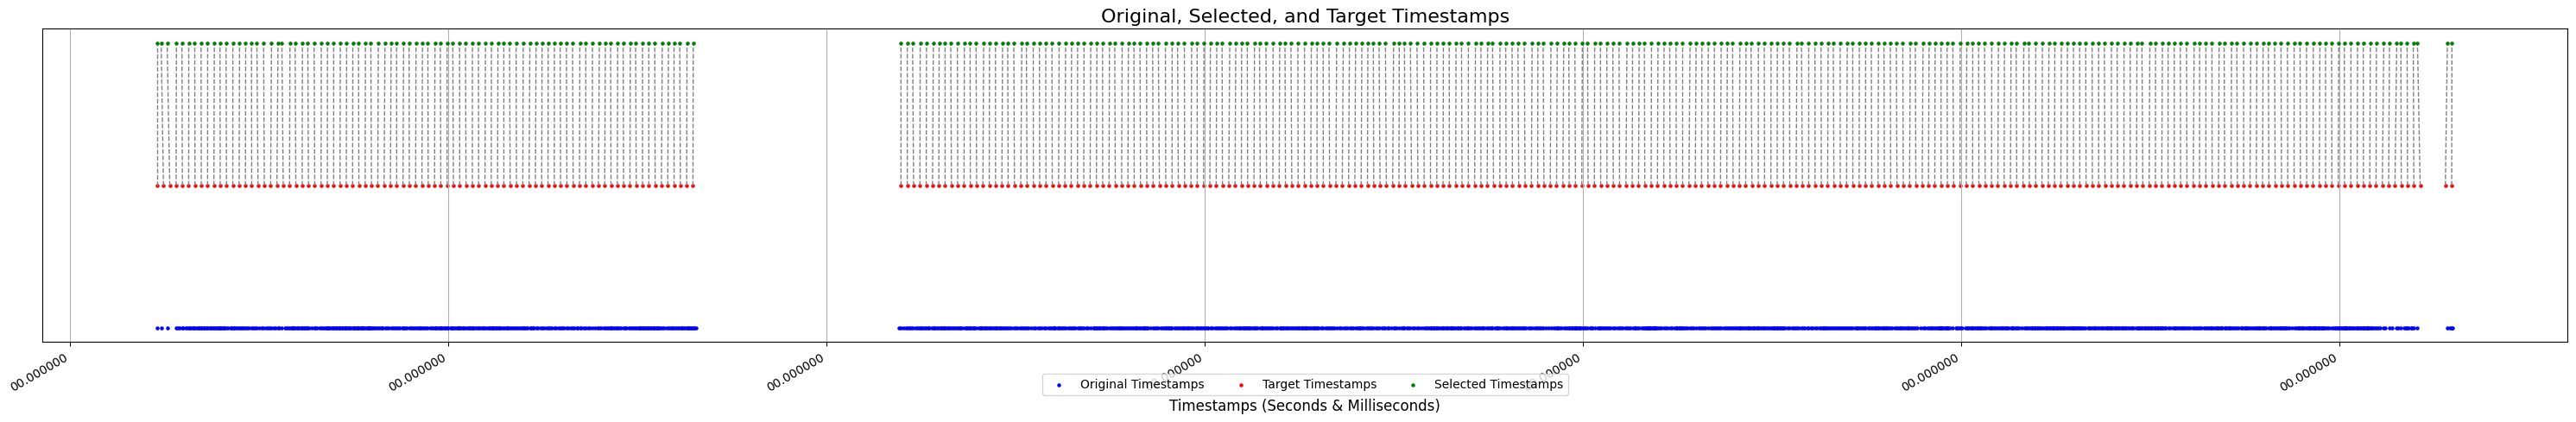

In [31]:
sampler = SampleTimestamps(file_path="/media/dbogdoll/Datasets/aws_s3_playground/sip-data-stream2-delivery-stream-2-2024-04-12-16-25-36-1b0621a6-479c-3c30-8603-0e243780bf94", target_framerate_hz=1)
framerate_hz, timestamps, upper_bound_threshold = sampler.get_framerate()
valid_target_framerate = sampler.check_target_framerate(framerate_hz)
if valid_target_framerate:
    selected_indices, selected_timestamps, target_timestamps, selected_target_timestamps = sampler.sample_timestamps(timestamps, upper_bound_threshold)
    sampler.update_file(selected_indices)
    sampler.plot_results(timestamps, selected_timestamps, selected_target_timestamps)